# Detect Clusters of Vegetation Areas
This notebook retrieves the centroids, using center of gravity, and the cluster points of all vegetation areas with a NDVI > 0.9

In [38]:
# Import necessary libraries
import pickle
import requests
import cv2
import pandas as pd
import rasterio
import subprocess
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx
import random
from IPython.display import Image

## Parameters

In [39]:
# Retrieve an image using rasdaman
service_endpoint = "https://ows.rasdaman.org/rasdaman/ows"
# Parameters
threshold = 0.9
output_format_tiff = "image/tiff"
output_file_tiff = "query_result.tiff"

## Get Tiff File

In [40]:
# CRS: 32631
# Sample: https://www.google.com/maps/@50.7240279,9.0168918,12z
query = '''
for $c in (S2_L2A_32631_B08_10m),
    $d in (S2_L2A_32631_B04_10m)

let $cutOut := [ ansi( "2021-04-09" ), E( 670000:679000 ), N( 4990220:4993220 ) ]
return
  encode( (

      (((float) $c - $d) / ((float) $c + $d)) [ $cutOut ] > {thr}
 ) * 255

  , "{outfrmt}")
'''.format(thr=threshold, outfrmt=output_format_tiff)

response = requests.post(service_endpoint, data = {'query': query}, verify=False)

# Save the response to a picture
print("Convert to tiff")
with open(output_file_tiff, "wb") as f:
    f.write(response.content)

/home/otto/PycharmProjects/JacobsHack-Team-9/jacobshack_venv/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ows.rasdaman.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Convert to tiff


## Get JPEG File

Convert to jpeg


/home/otto/PycharmProjects/JacobsHack-Team-9/jacobshack_venv/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ows.rasdaman.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


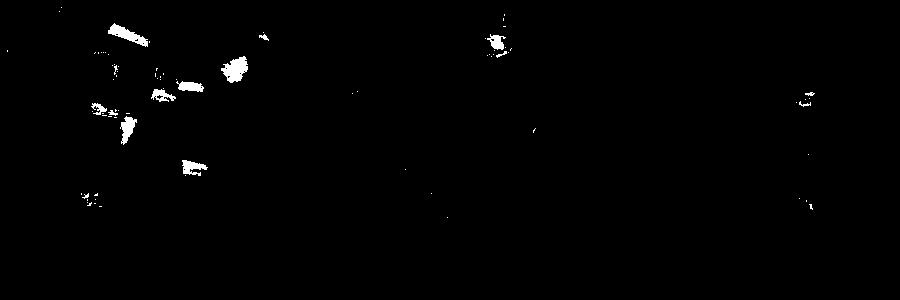

In [41]:
# Get the jpeg image
# TODO: Retrieve the image in 4326 coordinates from the server
# Link: https://doc.rasdaman.org/11_cheatsheets.html#coverage-operations (crsTransform)
query2 = '''
for $c in (S2_L2A_32631_B08_10m),
    $d in (S2_L2A_32631_B04_10m)

let $cutOut := [ ansi( "2021-04-09" ), E( 670000:679000 ), N( 4990220:4993220 ) ]
return
  encode( (

      (((float) $c - $d) / ((float) $c + $d)) [ $cutOut ] > {thr}
 ) * 255

  , "{outfrmt}")
'''.format(thr=threshold, outfrmt="image/jpeg")

response = requests.post(service_endpoint, data = {'query': query2}, verify=False)

# Save the response to a picture
print("Convert to jpeg")
with open("query_result.jpeg", "wb") as f:
    f.write(response.content)

Image(data=response.content)

## Preprocess the image

In [42]:
# Open the two files
im = cv2.imread("query_result.jpeg", cv2.IMREAD_GRAYSCALE) # Machine Visio
src = rasterio.open("query_result.tiff") # Coordinates

# Converting image to a binary image
# (black and white only image).
_, matrix = cv2.threshold(im, 110, 255,
                         cv2.THRESH_BINARY)

data2 = np.where(matrix == 255)
x2 = []
y2 = []

for i in range(data2[0].size):
    x2.append(data2[0][i])
    y2.append(data2[1][i])

data3 = list(zip(x2, y2))

pdData = pd.DataFrame(data3, columns =['x', 'y'])

## Perform clustering

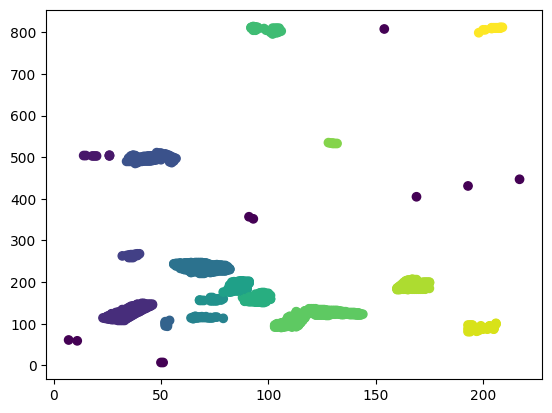

In [43]:
from sklearn.cluster import DBSCAN
# cluster the data into five clusters
dbscan = DBSCAN(eps = 8, min_samples = 4).fit(pdData) # fitting the model
labels = dbscan.labels_ # getting the labels

unique_labels = np.unique(labels)

plt.scatter(x2, y2, c=labels)
plt.show()

In [44]:
print("Number of unique labels = {unique_count}".format(unique_count=len(unique_labels)))

Number of unique labels = 17


## Get Centroids and Points for each Cluster

In [46]:
ourDict = {}

for i in range(unique_labels.size):
    ourDict[i] = {}
    ourDict[i]["Centroid"] = pdData[labels == unique_labels[i]].mean(0)
    ourDict[i]["Points"] = pdData[labels == unique_labels[i]]
    # With coordinates
    xs, ys = rasterio.transform.xy(src.transform, ourDict[i]["Centroid"][0], ourDict[i]["Centroid"][1])
    xsP, ysP = rasterio.transform.xy(src.transform, ourDict[i]["Points"]["x"], ourDict[i]["Centroid"]["y"])

    ourDict[i]["CentroidCoord"] = [xs, ys]

    # Get the coordinates of the centroid
    cent1 = ourDict[i]["CentroidCoord"][0]
    cent2 = ourDict[i]["CentroidCoord"][1]

    cmd = 'echo {} {} | gdaltransform -s_srs EPSG:32631 -t_srs EPSG:4326'.format(cent1, cent2)
    out = subprocess.check_output(cmd, shell=True).decode(encoding="utf-8").split()

    coordPoints = list(zip(xsP, ysP))
    ourDict[i]["PointsCoord"] = coordPoints

    coordPointsTrans = []

    for j in range(coordPoints.__len__()):
        cmd = 'echo {} {} | gdaltransform -s_srs EPSG:32631 -t_srs EPSG:4326'.format(coordPoints[j][0], coordPoints[j][1])
        out = subprocess.check_output(cmd, shell=True).decode(encoding="utf-8").split()

        coordPointsTrans.append([float(out[0]), float(out[1])])

    ourDict[i]["CentroidCoordTrans"] = [float(out[0]), float(out[1])]
    ourDict[i]["PointsCoordTrans"] = coordPointsTrans

ourDict

{0: {'Centroid': x    103.6
  y    293.4
  dtype: float64,
  'Points':         x    y
  0       7   61
  1      11   59
  586    50    7
  589    51    7
  1347   91  357
  1377   93  352
  1957  154  808
  2128  169  405
  2191  193  431
  2253  217  447,
  'CentroidCoord': [672939.0, 4992179.0],
  'PointsCoord': [(672939.0, 4993145.0),
   (672939.0, 4993105.0),
   (672939.0, 4992715.0),
   (672939.0, 4992705.0),
   (672939.0, 4992305.0),
   (672939.0, 4992285.0),
   (672939.0, 4991675.0),
   (672939.0, 4991525.0),
   (672939.0, 4991285.0),
   (672939.0, 4991045.0)],
  'CentroidCoordTrans': [5.19620928914418, 45.0517448467039],
  'PointsCoordTrans': [[5.19693295259336, 45.0706347766177],
   [5.19691916184968, 45.0702749691005],
   [5.1967847156941, 45.0667668444404],
   [5.19678126868102, 45.0666768924934],
   [5.19664340145036, 45.0630788132782],
   [5.1966365087696, 45.062898909249],
   [5.19642631314507, 45.0574118332257],
   [5.19637463493218, 45.0560625513073],
   [5.196291957373

## Calculating routes for each cluster using the centroids

In [49]:
# Download the road network
G = ox.graph_from_place('Bremen, Germany', network_type='drive')

In [50]:
centroid_list = []

for i in range(unique_labels.size):
    centroid_list.append(ourDict[i]["CentroidCoordTrans"])

centroid_list

[[5.19620928914418, 45.0517448467039],
 [5.2235525874632, 45.0684090088052],
 [5.17568987219669, 45.067530924908],
 [5.19303502276018, 45.0677391262775],
 [5.2226237653107, 45.0656365309954],
 [5.17225366614263, 45.0668762191808],
 [5.18928111462445, 45.064030414599],
 [5.17405591003936, 45.0645914520818],
 [5.17946239396158, 45.0644883566659],
 [5.18351127283878, 45.0633307615202],
 [5.17988708108326, 45.062499844362],
 [5.26172097102032, 45.060457666987],
 [5.17427985154919, 45.0587359941475],
 [5.22699550391679, 45.0587999489688],
 [5.18349370444903, 45.0557695537547],
 [5.17037680665264, 45.0532291267581],
 [5.26170470188167, 45.0511860906248]]

In [52]:
# Starting and ending point of a trip
start = [15.185539352132764,8.606855578588329]
endpoints = centroid_list

# Retrieve nearest nodes
nodes = []
for i in endpoints:
    nodes.append(ox.nearest_nodes(G, start, i))
nodes

[[1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760],
 [1437748760, 1437748760]]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

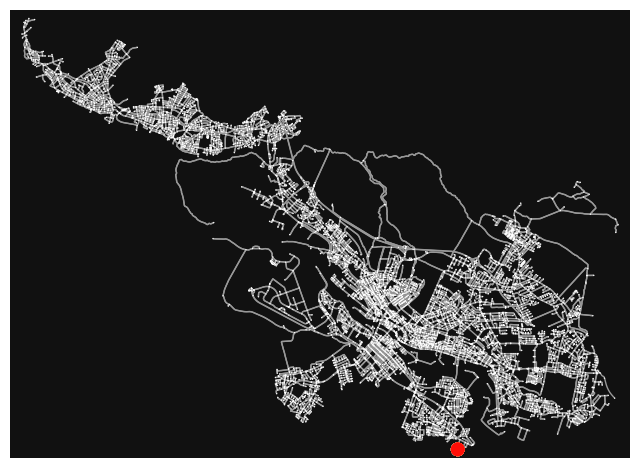

In [54]:
# Compute the paths of the trip
route_list = []
for i in nodes:
    route = nx.shortest_path(G, i[0], i[1], weight='length')
    route_list.append(route)

# Plot the trip
rc = cm.rainbow(np.linspace(0,1,len(route_list)))
fig, ax = ox.plot_graph_routes(G,
                              route_list,route_colors=rc,edge_linewidth=1,
                              node_size=1,
                              route_linewidth=6)